# CSCI316 Group Assignment 1
# Task 1
# Group: G18

In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn jupyter


^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

pd.set_option("display.max_columns", None)
sns.set_theme()


In [4]:
CSV_PATH = "apartments_for_rent_classified_10K.csv"  # change to your path if needed

df = pd.read_csv(CSV_PATH, sep=None, engine="python", encoding="cp1252")

df.columns = (df.columns
              .str.strip()
              .str.lower()
              .str.replace(r"\s+", "_", regex=True))

print(df.shape)
df.head()

(10000, 22)


,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,790,$790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,NaN,425,$425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,1390,"$1,390",Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,925,$925,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,880,$880,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401


In [ ]:

df.drop(columns=["price_display"], errors="ignore", inplace=True)

def extract_price_from_text(s: pd.Series) -> pd.Series:

    if s is None:
        return pd.Series([np.nan] * len(df))
    return (s.astype(str)
              .str.replace(",", "", regex=False)  #remove commas, keep digits
              .str.extract(r"(\d{3,6})")[0]
              .astype("float64"))

if "price" not in df.columns:
    candidate = None
    for col in ["title", "body"]:
        if col in df.columns:
            tmp = extract_price_from_text(df[col])
            if tmp.notna().sum() > 0:
                candidate = tmp
                break
    if candidate is None:
        raise ValueError("No 'price' column found and could not extract from text (title/body).")
    df["price"] = candidate


df = df[pd.to_numeric(df["price"], errors="coerce").notna()].copy()
df["price"] = df["price"].astype(float)


print(df["price"].describe())


count    10000.000000
mean      1486.277500
std       1076.507968
min        200.000000
25%        949.000000
50%       1270.000000
75%       1695.000000
max      52500.000000
Name: price, dtype: float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10000 non-null  int64  
 1   category      10000 non-null  object 
 2   title         10000 non-null  object 
 3   body          10000 non-null  object 
 4   amenities     6451 non-null   object 
 5   bathrooms     9966 non-null   float64
 6   bedrooms      9993 non-null   float64
 7   currency      10000 non-null  object 
 8   fee           10000 non-null  object 
 9   has_photo     10000 non-null  object 
 10  pets_allowed  5837 non-null   object 
 11  price         10000 non-null  float64
 12  price_type    10000 non-null  object 
 13  square_feet   10000 non-null  int64  
 14  address       6673 non-null   object 
 15  cityname      9923 non-null   object 
 16  state         9923 non-null   object 
 17  latitude      9990 non-null   float64
 18  longitude     9990 non-null

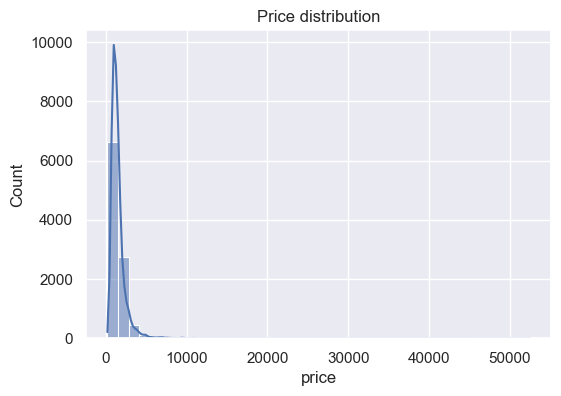

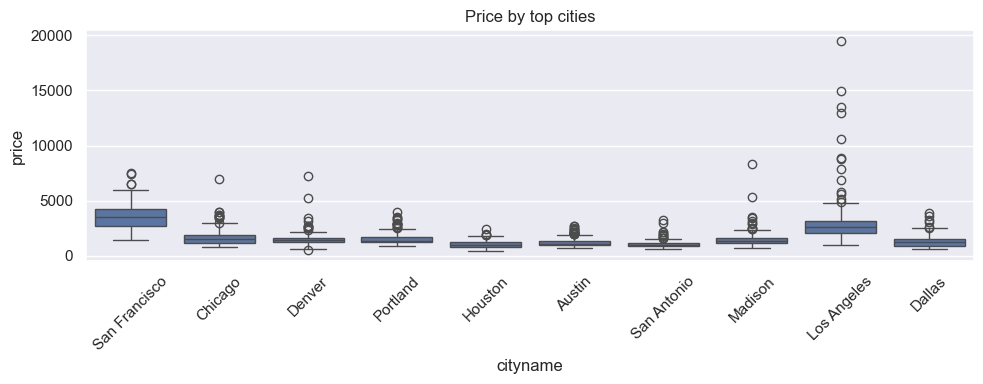

In [ ]:
print(df.info())  #shows column names, data types, null counts
print(df.isnull().sum().sort_values(ascending=False).head(10))  # Top missing-value columns

#plot price distribution
plt.figure(figsize=(6,4))
sns.histplot(df["price"], bins=40, kde=True)
plt.title("Price distribution")
plt.show()

    #plot boxplot for price by top cities
city_col = "cityname" if "cityname" in df.columns else None
if city_col:
    top = df[city_col].value_counts().head(10).index
    plt.figure(figsize=(10,4))
    sns.boxplot(data=df[df[city_col].isin(top)], x=city_col, y="price")
    plt.xticks(rotation=45)
    plt.title("Price by top cities")
    plt.tight_layout()
    plt.show()


In [ ]:
drop_candidates = [
    "id", "source",      #identifiers
    "price",             #target variable
    "price_display"      #redundant string representation of price
]
use_cols = [c for c in df.columns if c not in drop_candidates]

X = df[use_cols].copy()
y = df["price"].copy()

X.head()


,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price_type,square_feet,address,cityname,state,latitude,longitude,time
0,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,1577359415
1,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,NaN,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,1577017063
2,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,1577359410
3,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,1576667743
4,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,1577359401
